In [1]:
import glob
import matplotlib.pyplot
import matplotlib
import sys
import time
import math
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz, iirnotch, filtfilt, firwin, argrelextrema

# enable zooming into graphs
%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (10, 5)

def pull_data(dir_name, file_name, separator=','):
    f = open(dir_name + '/' + file_name + '.csv')
    xs = []
    ys = []
    zs = []
    rs = []
    timestamps = []
    f.readline() # ignore separator declaration
    f.readline() # ignore header
    for line in f:
        value = line.split(separator)
        if len(value) > 3:
            t=value[1].strip()
            timestamps.append(t)
            x = float(value[2])
            y = float(value[3])
            z = float(value[4])
            r = math.sqrt(x ** 2 + y ** 2 + z ** 2)
            xs.append(x)
            ys.append(y)
            zs.append(z)
            rs.append(r)
    return np.array(xs), np.array(ys), np.array(zs), np.array(rs), np.array(timestamps)

In [ ]:
"""
This file is used for extracting features.
"""

#HELPER function for other functions
#Separates the x, y, z coordinates into separate lists
def _separate_coordinates(window):
    x_coords = []
    y_coords = []
    z_coords = []
    coordinate_list = [x_coords, y_coords, z_coords]
    for i in range(0, 3):
        coordinate_list[i].extend(window[i])

    return coordinate_list

def compute_total_peaks(window):
    coordinate_list = _separate_coordinates(window)

    peak_arrays = []
    for i in coordinate_list:
        temp_array = np.array(i)
        peak_arrays.append(temp_array[argrelextrema(temp_array, np.greater)])

    peak_arrays_lengths = []
    for i in peak_arrays:
        peak_arrays_lengths.append(len(i))

    return peak_arrays_lengths


def compute_dfreq_range(window):
    coordinate_list = _separate_coordinates(window)

    ranges = [0, 0, 0]
    for i in range(0, 3):
        ranges[i] = max(coordinate_list[i]) - min(coordinate_list[i])
 
    return ranges
 

def extract_features(window):
    
    x = []
    feature_names = []
    
    x.append(compute_total_peaks(window))
    feature_names.append(["x_peaks", "y_peaks", "z_peaks"])
    
    x.append(compute_dfreq_range(window))
    feature_names.append(["x_dfreqs", "y_dfreqs", "z_dfreqs"])

    return feature_names, x



        

<IPython.core.display.Javascript object>


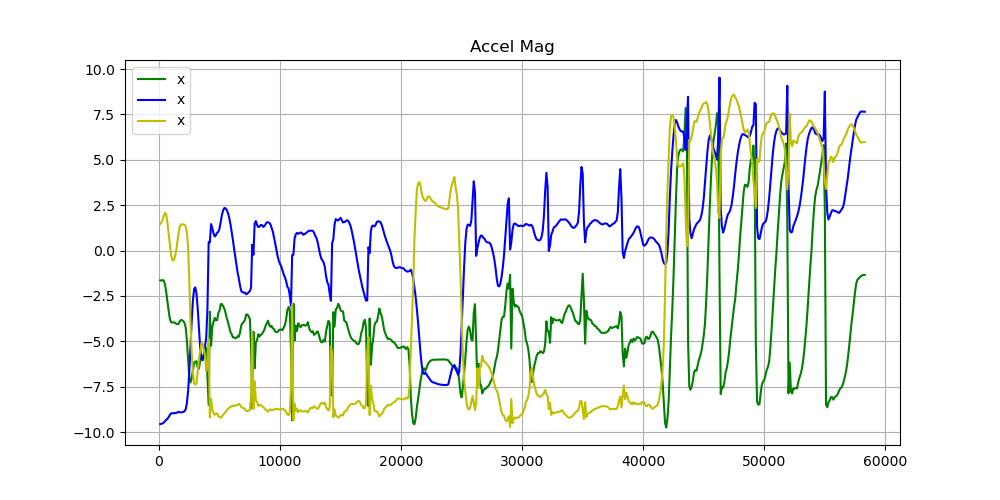

In [10]:
#Back hand throws (supposed to be 25)
b25_raw_data = pull_data('data', 'gravity')
(b25_accel_x, b25_accel_y, b25_accel_z, b25_accel_mag, b25_accel_time_temp) = b25_raw_data

b25_accel_time = b25_accel_time_temp.astype(int)

# start timestamps from zero (assume timestamps are in milliseconds)
plt.figure(figsize=(10,5))
#plt.plot(b25_accel_time, b25_accel_mag, 'r-',label="x")
plt.plot(b25_accel_time, b25_accel_x, 'g-',label="x")
plt.plot(b25_accel_time, b25_accel_y, 'b-',label="x")
plt.plot(b25_accel_time, b25_accel_z, 'y-',label="x")
plt.title("Accel Mag")
plt.legend(loc = 'upper left')
plt.grid()
plt.show()

In [ ]:
#Takes in a number and an array of numbers. Finds the index of the number in the array that is closest to the given number.
def find_closest_to_number(number_of_interest, array):
    current_smallest_difference = math.inf
    index_to_return = -1

    for i, number in enumerate(array):
        difference = abs(number_of_interest - number)
        if (difference <= current_smallest_difference):
            current_smallest_difference = difference
            index_to_return = i

    return index_to_return

def timestamps_array(mag, time):
    fs_average = sum(mag) / (len(mag) / 2)

    peak_arr = mag[argrelextrema(mag, np.greater)] 

    peaks = []
    times = []

    for y in peak_arr:
        if y > fs_average:
            peaks.append(y)
            
    for x in peaks:
        times.append(int(time[np.where(mag == x)]))
        
    return times


In [ ]:
FOREHAND = 0
BACKHAND = 0
HAMMER = 0

grav_data = pull_data('data', 'grav')

(grav_x, grav_y, grav_z, grav_mag, grav_time) = grav_data
timestamps = timestamps_array(b25_accel_mag, b25_accel_time)

def throw_classify(grav_x, grav_y, grav_z, grav_time):
    grav_x_value = grav_x[grav_time]
    grav_y_value = grav_y[grav_time]
    grav_z_value = grav_z[grav_time]
    if (grav_y_value > grav_x_value and grav_y_value > grav_z_value):
        return "FOREHAND"
    elif (grav_z_value >= 0):
        return "HAMMER"
    elif (grav_z_value < 0):
        return "BACKHAND"

def determine_throw_type(acc_array, gravity_array, timestamp_array):
    global FOREHAND
    global BACKHAND
    global HAMMER
    for timestamp in timestamp_array:
        index = find_closest_to_number(timestamp, grav_time)

        grav_x_value = grav_x[index]
        grav_y_value = grav_y[index]
        grav_z_value = grav_z[index]
        if (grav_y_value > grav_x_value and grav_y_value > grav_z_value):
            FOREHAND += 1
        elif (grav_z_value >= 0):
            HAMMER += 1
        elif (grav_z_value < 0):
            BACKHAND += 1


print(str(FOREHAND) + " forehand throws were performed.")
print(str(BACKHAND) + " backhand throws were performed.")
print(str(HAMMER) + " hammer throws were performed.")